In [1]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from torchvision import models, transforms
from tqdm import tqdm
import GradCam
import cv2
import matplotlib.pyplot as plt
from torch.autograd import Function

data_dir = 'flowers'
classes = ['rose', 'sunflower'] 


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval() 


def get_embedding(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).squeeze().numpy() 
    return embedding


c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\patri/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 14.5MB/s]


In [ ]:
embeddings = []
labels = []
file_paths = []

for label_idx, label_name in enumerate(classes):
    folder_path = os.path.join(data_dir, label_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            embedding = get_embedding(img_path, model, transform)
            embeddings.append(embedding)
            labels.append(label_idx)
            file_paths.append(img_path)
        except Exception as e:
            print(f"Could not process image {img_path}: {e}")


embeddings = np.array(embeddings)
labels = np.array(labels)
print(labels)

In [4]:
X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    embeddings, labels, file_paths, test_size=0.2, random_state=42, stratify=labels
)


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)


y_pred = rf_clf.predict(X_val)
print("Accuracy on validation set:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, target_names=classes))

Accuracy on validation set: 0.9769736842105263
              precision    recall  f1-score   support

        rose       0.97      0.98      0.98       157
   sunflower       0.98      0.97      0.98       147

    accuracy                           0.98       304
   macro avg       0.98      0.98      0.98       304
weighted avg       0.98      0.98      0.98       304



In [5]:
n_prototypes = 20
selected_prototypes = {label: [] for label in classes}

for label_idx, label_name in enumerate(classes):
    
    class_embeddings = embeddings[labels == label_idx]
    class_paths = np.array(file_paths)[labels == label_idx]

    
    kmeans = KMeans(n_clusters=n_prototypes, random_state=42)
    kmeans.fit(class_embeddings)
    
   
    for cluster_center in kmeans.cluster_centers_:
        distances = np.linalg.norm(class_embeddings - cluster_center, axis=1)
        closest_idx = np.argmin(distances)
        selected_prototypes[label_name].append(class_paths[closest_idx])


for label, prototypes in selected_prototypes.items():
    print(f"\nSelected prototypes for class '{label}':")
    for prototype in prototypes:
        print(prototype)

c:\Users\patri\Python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\patri\Python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



Selected prototypes for class 'rose':
flowers\rose\5001844187_0a77b2eed6_n.jpg
flowers\rose\5001848135_63300a26a8_n.jpg
flowers\rose\27619697563_228f5c4677_n.jpg
flowers\rose\12202373204_34fb07205b.jpg
flowers\rose\4860145119_b1c3cbaa4e_n.jpg
flowers\rose\18599603859_f2ec616ddf_n.jpg
flowers\rose\7461898018_7e12128f14_n.jpg
flowers\rose\6690926183_afedba9f15_n.jpg
flowers\rose\13279526615_a3b0059bec.jpg
flowers\rose\921138131_9e1393eb2b_m.jpg
flowers\rose\3268459296_a7346c6b2c.jpg
flowers\rose\3948347096_42261f047a_m.jpg
flowers\rose\2059172936_032ffc12aa.jpg
flowers\rose\7456196174_f9de97ba73_n.jpg
flowers\rose\1469726748_f359f4a8c5.jpg
flowers\rose\4900231976_f8ced2b42a_n.jpg
flowers\rose\18490508225_0fc630e963_n.jpg
flowers\rose\4625089819_55c45a189c.jpg
flowers\rose\5001847693_77a9fb4f3c_n.jpg
flowers\rose\5694071486_90c2b1aee5_n.jpg

Selected prototypes for class 'sunflower':
flowers\sunflower\2694860538_b95d60122c_m.jpg
flowers\sunflower\3798841385_38142ea3c6_n.jpg
flowers\sunfl

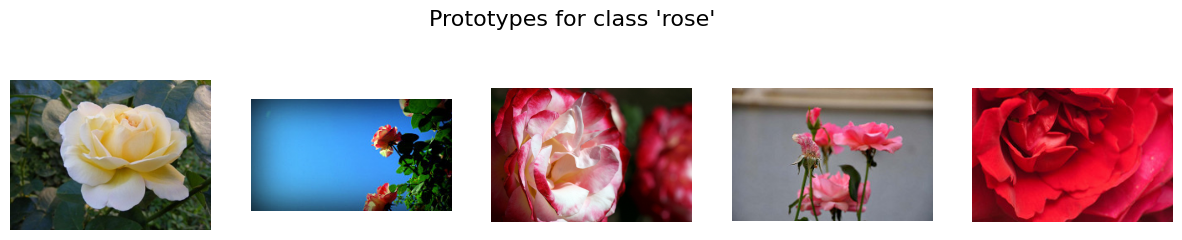

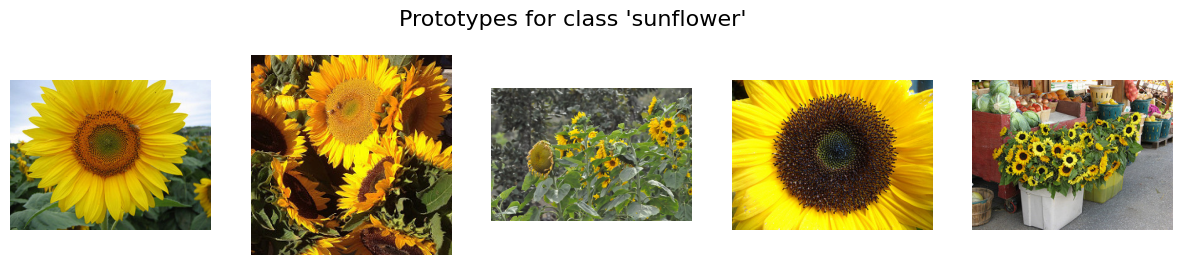

In [10]:
def visualize_prototypes(selected_prototypes, classes, grid_size=(1, 5)):
    for label, prototypes in selected_prototypes.items():
        
        n_prototypes = len(prototypes)
        rows, cols = grid_size if n_prototypes >= grid_size[1] else (1, n_prototypes)
        
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3))
        fig.suptitle(f"Prototypes for class '{label}'", fontsize=16)
        
        
        for idx, prototype_path in enumerate(prototypes):
           
            row = idx // cols
            col = idx % cols
            
            
            image = Image.open(prototype_path)
            if rows == 1:  
                ax = axes[col] if cols > 1 else axes
            else:
                ax = axes[row, col]
            ax.imshow(image)
            ax.axis('off')
        
       
        for extra in range(idx + 1, rows * cols):
            fig.delaxes(axes.flat[extra])

        
        plt.show()


visualize_prototypes(selected_prototypes, classes)


In [49]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

In [58]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)  


In [59]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [60]:
test_images = {
    'rose': 'test_images/roses.jpg',      
    'sunflower': 'test_images/sunflower.jpg' 
}

In [61]:
def map_to_dataset_classes(class_idx):
    class_mapping = {0: 'rose', 1: 'sunflower'}
    return class_mapping.get(class_idx, "Unknown")


In [62]:
grad_cam = GradCam.GradCAM(model, model.layer4[2].conv3)

Model output: tensor([[ 0.5025, -0.1342]])
Predicted class index: 0


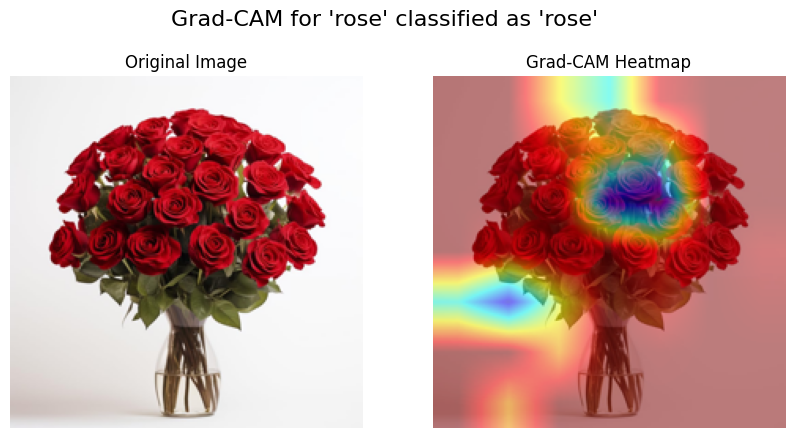

Model output: tensor([[ 0.4816, -0.1625]])
Predicted class index: 0


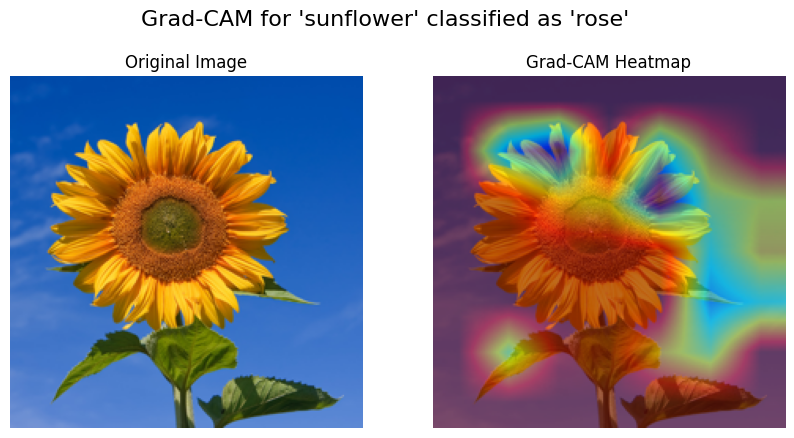

In [63]:
for label, img_path in test_images.items():
    
    image_tensor = preprocess_image(img_path)
    image = Image.open(img_path).resize((224, 224))


    with torch.no_grad():
        output = model(image_tensor)
    class_idx = output.argmax(dim=1).item()
    print("Model output:", output)
    print("Predicted class index:", class_idx)



    predicted_label = classes[class_idx]


    cam = grad_cam(image_tensor, class_idx)


    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(image), 0.5, heatmap, 0.5, 0)


    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Grad-CAM for '{label}' classified as '{predicted_label}'", fontsize=16)

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.show()


In [14]:
prototypes = {
    'rose': 'flowers/rose/1949195327_75f76c12b1.jpg',      
    'sunflower': 'flowers/sunflower/8928658373_fdca5ff1b8.jpg' }

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

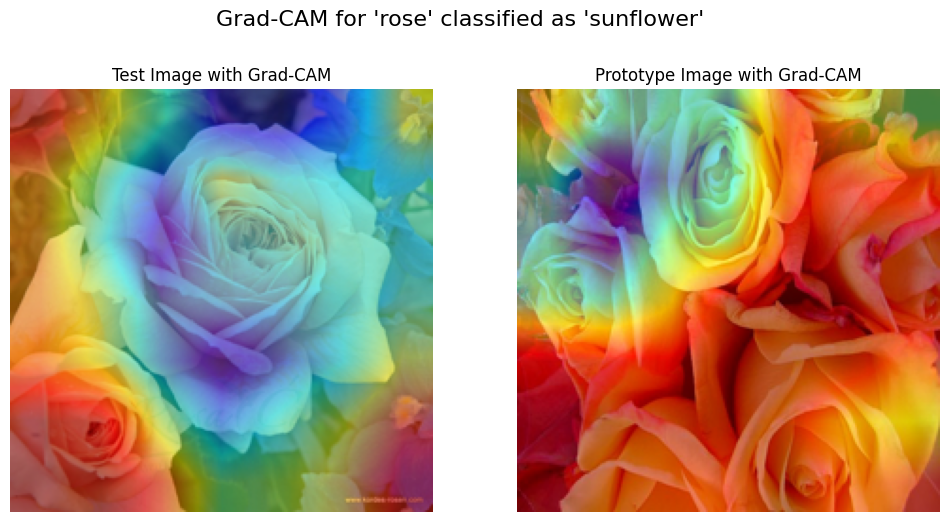

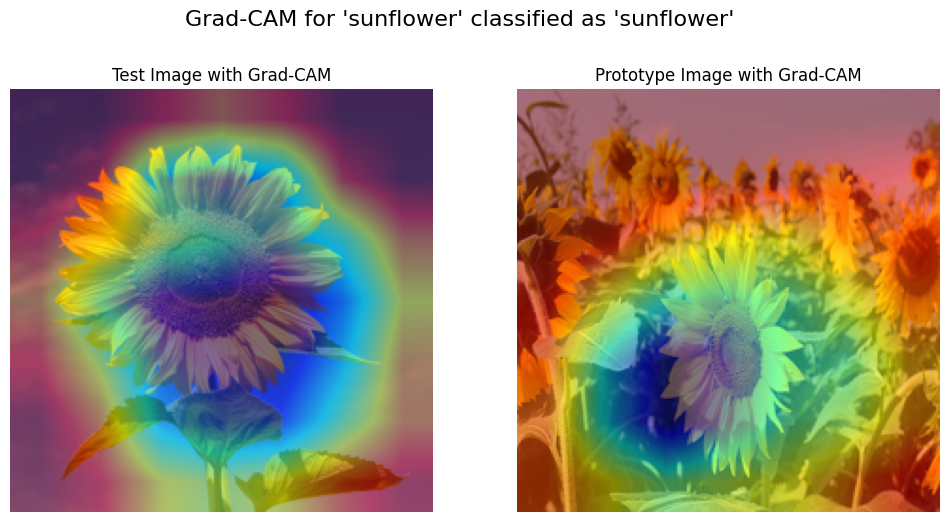

In [16]:
for label, img_path in test_images.items():
    
    image_tensor = preprocess_image(img_path)
    prototype_tensor = preprocess_image(prototypes[label])
    
    image = Image.open(img_path).resize((224, 224))
    prototype_image = Image.open(prototypes[label]).resize((224, 224))

   
    with torch.no_grad():
        output = model(image_tensor)
    class_idx = output.argmax(dim=1).item()

    
    predicted_label = map_to_dataset_classes(class_idx)

    
    cam_test = grad_cam(image_tensor, class_idx)
    cam_prototype = grad_cam(prototype_tensor, class_idx)

    
    heatmap_test = cv2.applyColorMap(np.uint8(255 * cam_test), cv2.COLORMAP_JET)
    overlay_test = cv2.addWeighted(np.array(image), 0.5, heatmap_test, 0.5, 0)

    heatmap_prototype = cv2.applyColorMap(np.uint8(255 * cam_prototype), cv2.COLORMAP_JET)
    overlay_prototype = cv2.addWeighted(np.array(prototype_image), 0.5, heatmap_prototype, 0.5, 0)

    
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Grad-CAM for '{label}' classified as '{predicted_label}'", fontsize=16)

    
    plt.subplot(1, 2, 1)
    plt.imshow(overlay_test)
    plt.title("Test Image with Grad-CAM")
    plt.axis('off')

    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay_prototype)
    plt.title("Prototype Image with Grad-CAM")
    plt.axis('off')

    plt.show()

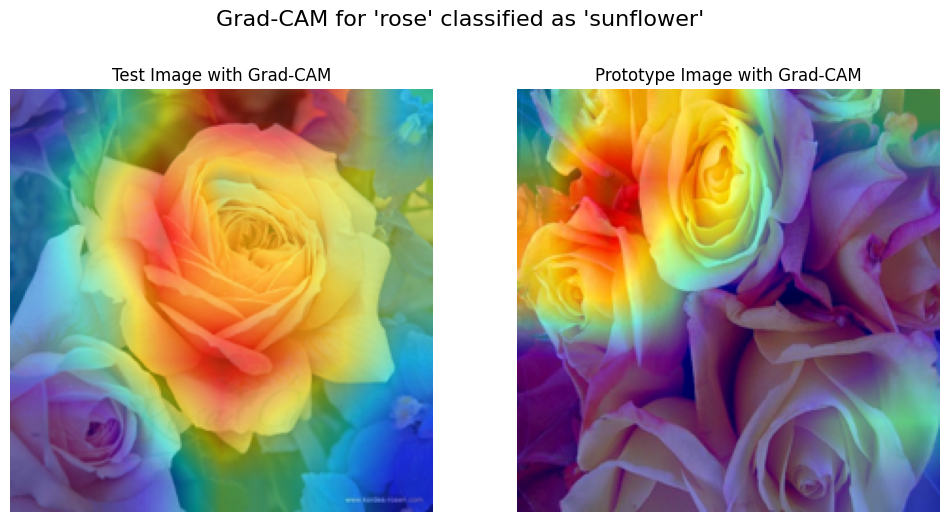

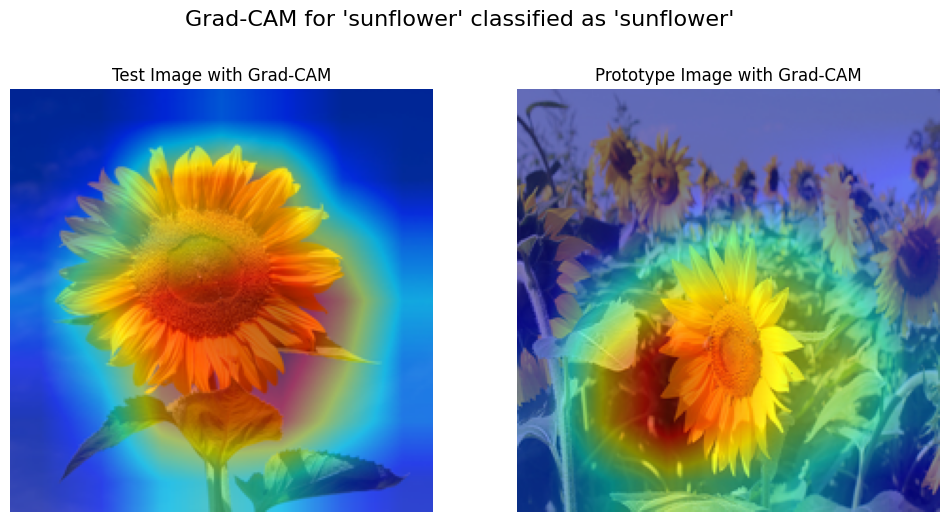

In [17]:
for label, img_path in test_images.items():
    
    image_tensor = preprocess_image(img_path)
    prototype_tensor = preprocess_image(prototypes[label])
    
    image = Image.open(img_path).resize((224, 224))
    prototype_image = Image.open(prototypes[label]).resize((224, 224))

    
    with torch.no_grad():
        output = model(image_tensor)
    class_idx = output.argmax(dim=1).item()

    
    predicted_label = map_to_dataset_classes(class_idx)

    
    cam_test = grad_cam(image_tensor, class_idx)
    cam_prototype = grad_cam(prototype_tensor, class_idx)

    
    heatmap_test = cv2.applyColorMap(np.uint8(255 * (1 - cam_test)), cv2.COLORMAP_JET)
    overlay_test = cv2.addWeighted(np.array(image), 0.5, heatmap_test, 0.5, 0)

    heatmap_prototype = cv2.applyColorMap(np.uint8(255 * (1 - cam_prototype)), cv2.COLORMAP_JET)
    overlay_prototype = cv2.addWeighted(np.array(prototype_image), 0.5, heatmap_prototype, 0.5, 0)

   
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Grad-CAM for '{label}' classified as '{predicted_label}'", fontsize=16)

    
    plt.subplot(1, 2, 1)
    plt.imshow(overlay_test)
    plt.title("Test Image with Grad-CAM")
    plt.axis('off')

    
    plt.subplot(1, 2, 2)
    plt.imshow(overlay_prototype)
    plt.title("Prototype Image with Grad-CAM")
    plt.axis('off')

    plt.show()

In [18]:
def occlusion_sensitivity(image_tensor, occlusion_size=56, stride=28):
    occlusion_map = np.zeros((image_tensor.shape[2], image_tensor.shape[3]))
    original_output = model(image_tensor).detach().numpy()
    original_class = original_output.argmax()

   
    for i in range(0, image_tensor.shape[2] - occlusion_size + 1, stride):
        for j in range(0, image_tensor.shape[3] - occlusion_size + 1, stride):
            occluded_image_tensor = image_tensor.clone()
            
            occlusion_mask = np.ones((occlusion_size, occlusion_size, 3)) * 0.5
            occluded_image_tensor[0, :, i:i + occlusion_size, j:j + occlusion_size] = torch.tensor(occlusion_mask).permute(2, 0, 1)

            
            output = model(occluded_image_tensor).detach().numpy()
            occlusion_map[i:i + occlusion_size, j:j + occlusion_size] = output[0, original_class] - original_output[0, original_class]

    return occlusion_map

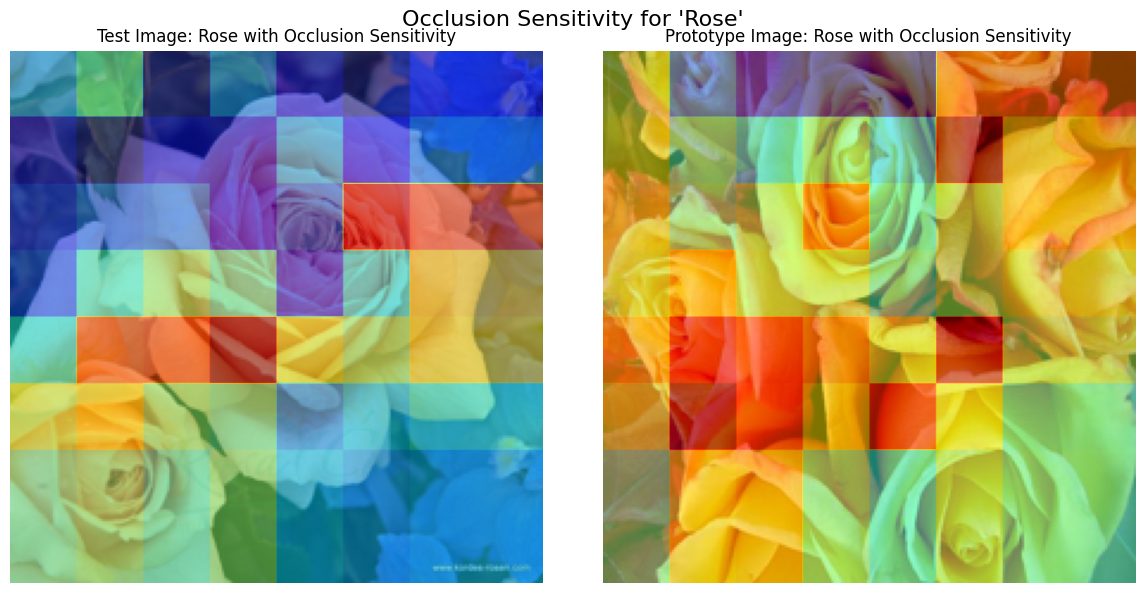

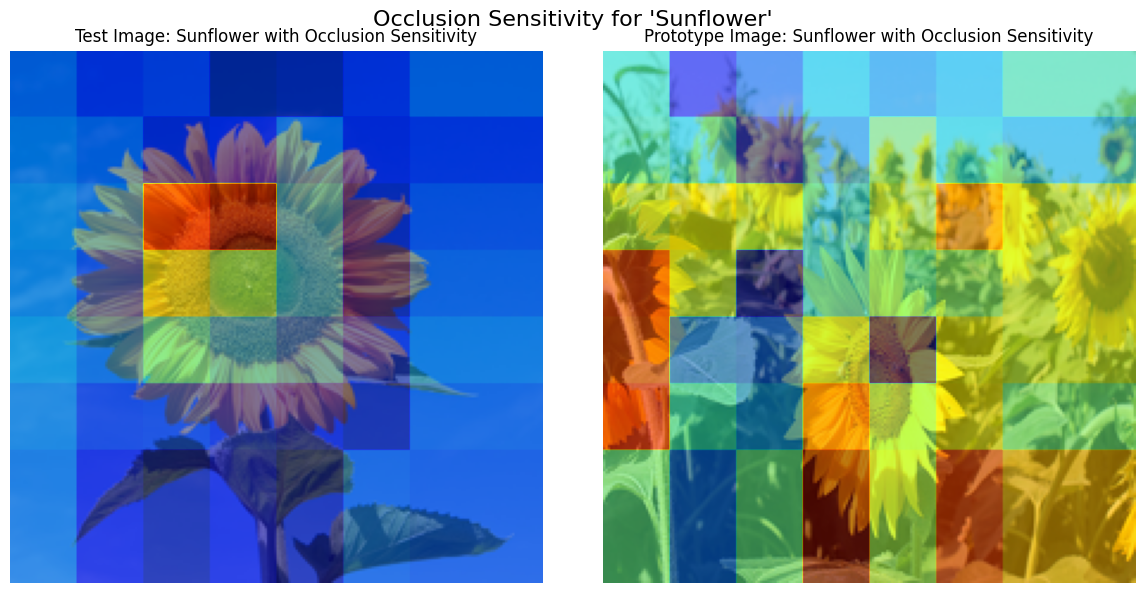

In [19]:
for label, img_path in test_images.items():

    image_tensor = preprocess_image(img_path)
    prototype_tensor = preprocess_image(prototypes[label])
    
    image = Image.open(img_path).resize((224, 224))
    prototype_image = Image.open(prototypes[label]).resize((224, 224))

   
    occlusion_test = occlusion_sensitivity(image_tensor)
    occlusion_prototype = occlusion_sensitivity(prototype_tensor)

   
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Occlusion Sensitivity for '{label.capitalize()}'", fontsize=16)

    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.imshow(occlusion_test, cmap='jet', alpha=0.5) 
    plt.title(f"Test Image: {label.capitalize()} with Occlusion Sensitivity")
    plt.axis('off')

    
    plt.subplot(1, 2, 2)
    plt.imshow(prototype_image)
    plt.imshow(occlusion_prototype, cmap='jet', alpha=0.5) 
    plt.title(f"Prototype Image: {label.capitalize()} with Occlusion Sensitivity")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [23]:
os.makedirs('saved_models', exist_ok=True)

torch.save(model.state_dict(), 'saved_models/resnet50_model.pth')